<a href="https://colab.research.google.com/github/baroneleonardo/NO2-Virtual-Sensor/blob/main/NN_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv("data_dausare.csv")
data = data.set_index('Datetime')
data.describe()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S5(O3),T,RH,AH
count,8991.000000,8991.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,1099.707856,939.029205,835.370973,113.075515,1022.780725,18.316054,49.232360,1.025530
std,217.084571,266.829000,256.815106,48.359250,398.480897,8.832888,17.316389,0.403813
min,647.250000,383.250000,322.000000,2.000000,221.000000,-1.900000,9.175000,0.184679
25%,936.750000,734.375000,657.875000,78.000000,731.375000,11.787500,35.812500,0.736769
50%,1063.000000,909.000000,805.500000,109.000000,963.250000,17.750000,49.550000,0.995395
75%,1231.250000,1116.250000,969.250000,142.000000,1273.375000,24.400000,62.500001,1.313701
max,2039.750000,2214.000000,2682.750000,339.700000,2522.750000,44.600000,88.725000,2.231036


In [7]:
data = data.dropna(subset=["NO2(GT)"])
data = data.dropna(subset=["T"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7393 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    7393 non-null   float64
 1   PT08.S2(NMHC)  7393 non-null   float64
 2   PT08.S3(NOx)   7393 non-null   float64
 3   NO2(GT)        7393 non-null   float64
 4   PT08.S5(O3)    7393 non-null   float64
 5   T              7393 non-null   float64
 6   RH             7393 non-null   float64
 7   AH             7393 non-null   float64
dtypes: float64(8)
memory usage: 519.8+ KB


In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(11,11))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(data, data.columns)

In [4]:
threshold = 6 # theshold a little high to retain some outliers
z_scores = np.abs((data - data.mean()) / data.std())
outliers = (z_scores > threshold).any(axis=1)
for column in data.columns:
    column_median = data[column].median()
    data.loc[outliers, column] = column_median

In [8]:
# Normalize the data, this is a rudimentary MinMaxScaler
max_df = data.max()
min_df = data.min()

data_norm = (data - min_df)/(max_df - min_df)
data_norm = pd.DataFrame(data_norm, columns=data.columns)

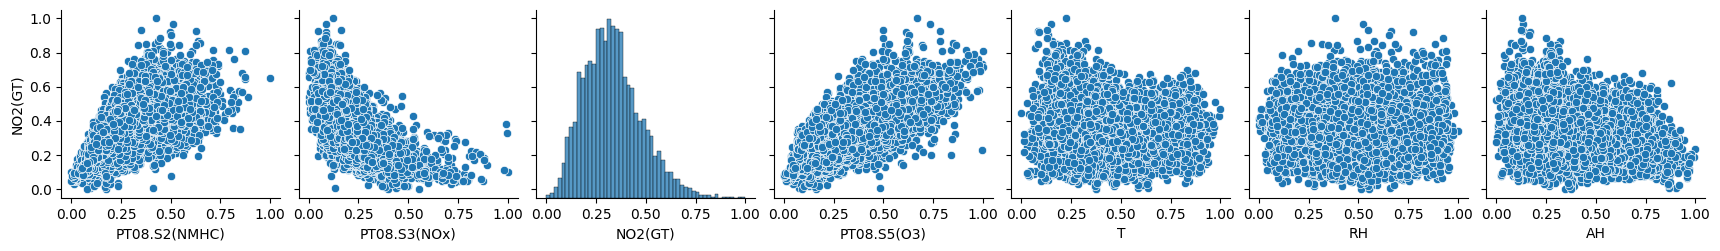

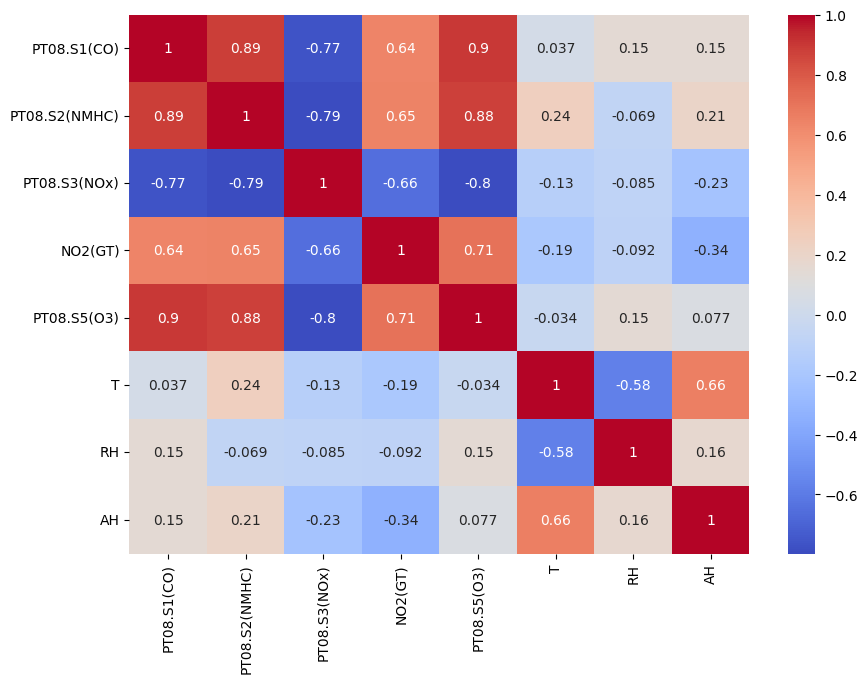

In [5]:
correlations = data_norm.corr()
# Scatter plots
sns.pairplot(data_norm, x_vars=data_norm.columns[1:], y_vars=['NO2(GT)'])

# Heat map
plt.figure(figsize=(10, 7))
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.show()

#### Talk first easy NN just to see the difference in the data-cleaning part

In [9]:
import tensorflow as tf
import os
import random
import seaborn as sns
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L1

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers
tf.config.set_visible_devices([], 'GPU') #disables GPU
print(tf.__version__)

2.12.0


In [10]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [8]:
data

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),NO2(GT),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,
2004-03-10 18:00:00,1360.00,1045.50,1056.25,113.0,1267.50,13.600,48.875001,0.757754
2004-03-10 19:00:00,1292.25,954.75,1173.75,92.0,972.25,13.300,47.700000,0.725487
2004-03-10 20:00:00,1402.00,939.25,1140.00,114.0,1074.00,11.900,53.975000,0.750239
2004-03-10 21:00:00,1375.50,948.25,1092.00,122.0,1203.25,11.000,60.000000,0.786713
2004-03-10 22:00:00,1272.25,835.50,1205.00,116.0,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,1314.25,1101.25,538.50,189.8,1728.50,21.850,29.250000,0.756824
2005-04-04 11:00:00,1162.50,1027.00,603.75,179.2,1269.00,24.325,23.725000,0.711864
2005-04-04 12:00:00,1142.00,1062.50,603.25,174.7,1092.00,26.900,18.350000,0.640649


In [11]:
# just to prove that is the same as the classic MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

target = pd.DataFrame(data['NO2(GT)'])
X = data.drop(['NO2(GT)'], axis=1)
print('NO2" data_normset shape',X.shape)
print('Target shape', target.shape)
X.describe()

scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled, columns=X.columns)

#do the same for y

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target) 
y_scaled = pd.DataFrame(y_scaled, columns=target.columns)


y_scaled.describe()   
x_scaled.describe()

NO2" data_normset shape (7393, 7)
Target shape (7393, 1)


,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S5(O3),T,RH,AH
count,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000
mean,0.333748,0.309864,0.212836,0.358246,0.427159,0.497782,0.405859
std,0.156757,0.144993,0.108836,0.176336,0.193585,0.219921,0.202238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.217056,0.199918,0.138304,0.228956,0.283333,0.326210,0.257746
50%,0.309156,0.295917,0.198877,0.334419,0.408602,0.500629,0.390793
75%,0.430162,0.406527,0.267923,0.471924,0.558065,0.666248,0.544303
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
#split in test and train

# X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, random_state=seed, shuffle=True)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

test_size = int(0.20*7393)

X_train = x_scaled.iloc[:-test_size]
y_train = y_scaled.iloc[:-test_size]
X_test = x_scaled.iloc[-test_size:]
y_test = y_scaled.iloc[-test_size:]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5915, 7) (5915, 1)
(1478, 7) (1478, 1)


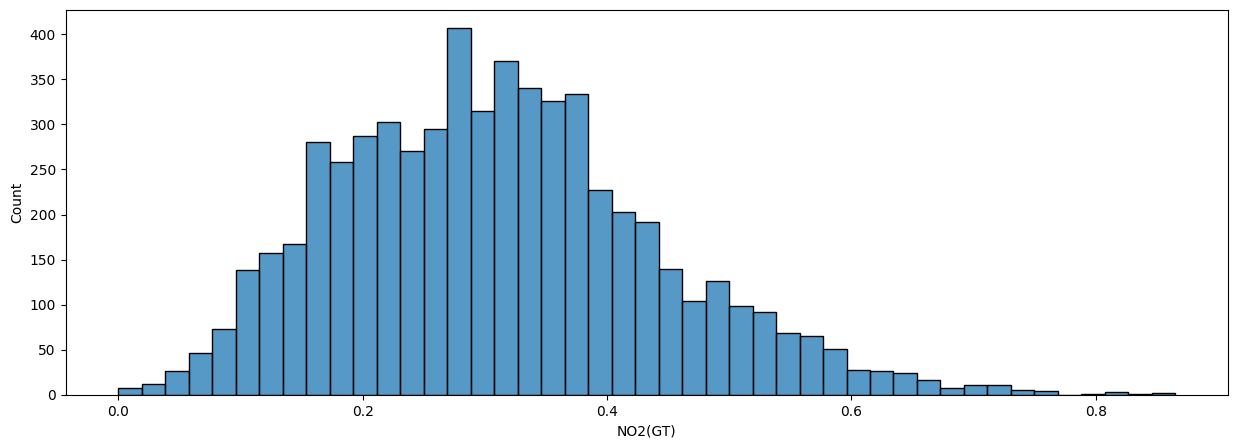

In [13]:
# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=y_train, x='NO2(GT)')
plt.show()

In [14]:
input_shape = X_train.shape[1:]
input_shape

(7,)

### PROVA 1

In [ ]:
def build_ffnn(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    layer = tfkl.Dense(units=512, activation='relu')(input_layer)
    layer = tfkl.Dense(units=512, activation='relu')(layer)
    layer = tfkl.Dropout(rate=0.5)(layer)
    layer = tfkl.Dense(units=512, activation='relu')(layer)
    output_layer = tfkl.Dense(units=1, activation='linear', name='Output')(layer)


    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='FFNN')

    # Compile the model
    loss = tfk.losses.MeanSquaredError()
    learning_rate = 0.2
    optimizer = tfk.optimizers.legacy.SGD(learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()])

    # Return the model
    return model

In [ ]:
ffnn = build_ffnn(input_shape)
ffnn.summary()

Model: "FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 7)]               0         
                                                                 
 dense_67 (Dense)            (None, 512)               4096      
                                                                 
 dense_68 (Dense)            (None, 512)               262656    
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_69 (Dense)            (None, 512)               262656    
                                                                 
 Output (Dense)              (None, 1)                 513       
                                                                 
Total params: 529,921
Trainable params: 529,921
Non-trainable 

In [ ]:
batch_size = 128
epochs = 5000

In [ ]:
history = ffnn.fit(
    x = X_train,
    y = y_train, 
    batch_size = batch_size,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100,  restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=50, factor=0.5, min_lr=1e-5)
                            ],
    epochs = epochs
).history

In [ ]:
scores = ffnn.evaluate(X_test, y_test, verbose=1)
print("RMSE: %.2f%%" % (scores[2]*100))
scores

47/47 [==============================] - 0s 3ms/step - loss: 0.0112 - mean_absolute_error: 0.0801 - root_mean_squared_error: 0.1058
Accuracy: 8.01%


[0.011198282241821289, 0.0800924003124237, 0.10582193732261658]

In [ ]:
y_pred=ffnn.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 3ms/step
MSE 0.011198282202743952
R2 0.5538280277940697


In [ ]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred)))
print("R2",r2_score(scaler_y.inverse_transform(y_test),scaler_y.inverse_transform(y_pred)))

MSE 1149.2869458931557
R2 0.5810389467084569


In [ ]:
def plot_residuals(model, X_, y_):
    X_['sort'] = y_
    X_ = X_.sort_values(by=['sort'])
    y_ = np.expand_dims(X_['sort'], 1)
    X_.drop(['sort'], axis=1, inplace=True)

    y_pred = model.predict(X_)
    SSE = np.square(scaler_y.inverse_transform(y_pred) - scaler_y.inverse_transform(y_))
    MSE = np.mean(SSE)

    print('Mean Squared Error (MSE):', MSE)
    # mpl.rcParams.update(mpl.rcParamsDefault)
    # sns.set(font_scale=1.1, style=None, palette='Set1')
    plt.figure(figsize=(15,5))
    plt.scatter(np.arange(len(y_)), y_, label='True')
    plt.scatter(np.arange(len(y_pred)), y_pred, label='Prediction')
    
    for i in range(len(y_)):
        if(y_[i]>=y_pred[i]):
            plt.vlines(i,y_pred[i],y_[i],alpha=.5)
        else:
            plt.vlines(i,y_[i],y_pred[i],alpha=.5)
            
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

In [ ]:
plot_residuals(ffnn, X_test, y_test)

In [ ]:
plot_residuals(ffnn, X_train, y_train)

### Prova diversa ffnn

In [26]:
def build_ffnn_LLL(input_shape):
  
    model = tf.keras.Sequential()
    model.add(tfkl.Dense(512, activation='relu', input_shape=input_shape))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.5))
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()])

    return model


In [23]:
def build_ffnn_LLL(input_shape):
    model = tf.keras.Sequential()
    model.add(tfkl.Dense(512, activation='relu', input_shape=input_shape))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.5))
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.4))
    model.add(tfkl.Dense(256, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()])

    return model


In [15]:
def build_ffnn_LLL(input_shape):
  model = tfk.Sequential()
  model.add(tfkl.Dense(128, activation='relu', input_shape=(7,)))
  model.add(tfkl.Dropout(0.2))
  model.add(tfkl.Dense(64, activation='relu'))
  model.add(tfkl.Dropout(0.2))
  model.add(tfkl.Dense(32, activation='relu'))
  model.add(tfkl.Dropout(0.2))
  model.add(tfkl.Dense(16, activation='relu'))
  model.add(tfkl.Dense(1, activation='linear'))  # Output layer senza funzione di attivazione per la regressione

  # Compila il modello
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()])
  return model

In [ ]:
input_shape = X_train.shape[1:]
batch_size = 64
epochs = 300
ffnn = build_ffnn_LLL(input_shape)
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)]

history = ffnn.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)


In [28]:
scores = ffnn.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
scores

47/47 [==============================] - 0s 3ms/step - loss: 0.0130 - mean_absolute_error: 0.0883 - root_mean_squared_error: 0.1139
Accuracy: 8.83%


[0.01296425424516201, 0.08828582614660263, 0.11386068165302277]

In [18]:
y_pred=ffnn.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 1ms/step
MSE 0.012467957899144877
R2 0.5032404734469996


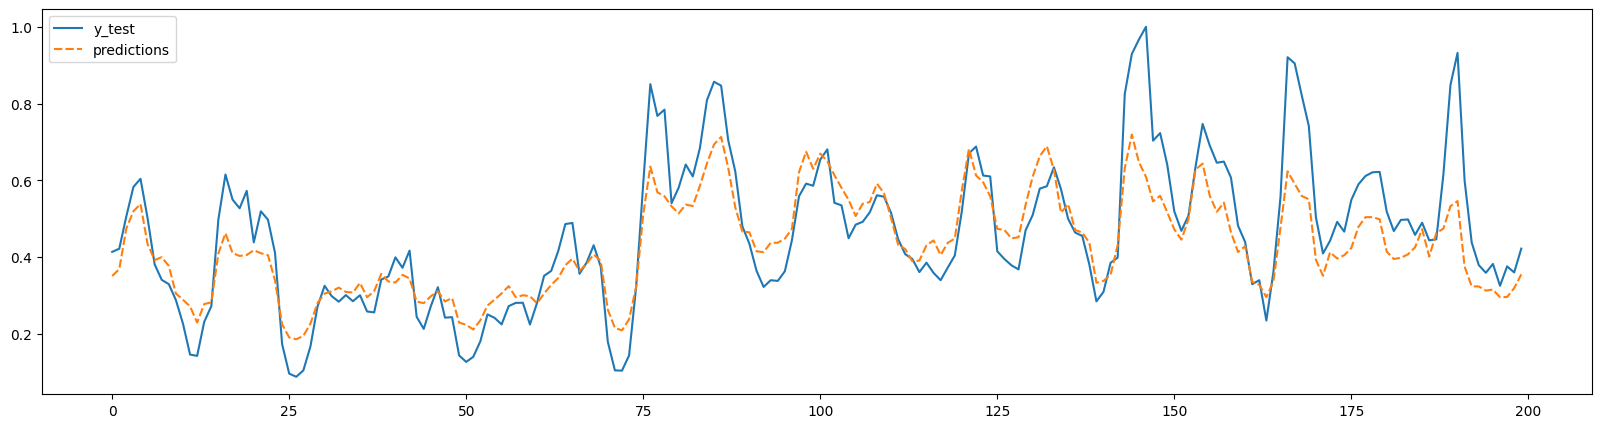

In [ ]:

aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:, :])
plt.show()

### RECURRENT NN

In [ ]:
def build_rnn(input_shape):
    model = tf.keras.Sequential()
    model.add(tfkl.LSTM(256, activation='relu', input_shape=(input_shape[1], input_shape[2])))
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.5))
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()])

    return model

In [ ]:
X_train_reshaped = np.expand_dims(X_train, axis=1)
input_shape = X_train_reshaped.shape
batch_size = 128
epochs = 300
rnn = build_rnn(input_shape)
rnn.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               270336    
                                                                 
 dense_84 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_26 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 512)               0         
                                                                 
 dense_85 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_27 (Bat  (None, 512)              2048      
 chNormalization)                                    

In [ ]:
history = rnn.fit(
    X_train_reshaped, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    ]
)

In [ ]:
x_test_reshaped = np.expand_dims(X_test, axis=1)
scores = rnn.evaluate(x_test_reshaped, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
scores

47/47 [==============================] - 0s 5ms/step - loss: 0.0151 - mean_absolute_error: 0.0947 - root_mean_squared_error: 0.1228
Accuracy: 9.47%


[0.01507224328815937, 0.09473196417093277, 0.1227690652012825]

In [ ]:
y_pred=rnn.predict(x_test_reshaped)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 1s 7ms/step
MSE 0.013095725569400462
R2 0.4782283926247799


PROVA 2

In [29]:
def build_rnn2(input_shape):
    model = tf.keras.Sequential()
    model.add(tfkl.LSTM(128, activation='tanh', input_shape=(input_shape[1], input_shape[2]), return_sequences=True))
    model.add(tfkl.LSTM(64, activation='tanh', return_sequences=False))
    model.add(tfkl.Dense(256, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.3))
    model.add(tfkl.Dense(128, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.3))
    model.add(tfkl.Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()])

    return model


In [30]:
X_train_reshaped = np.expand_dims(X_train, axis=1)
input_shape = X_train_reshaped.shape
batch_size = 64
epochs = 300
rnn2 = build_rnn2(input_shape)
history = rnn2.fit(
    X_train_reshaped, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/300
74/74 [==============================] - 8s 25ms/step - loss: 0.0799 - mean_absolute_error: 0.1683 - root_mean_squared_error: 0.2827 - val_loss: 0.0237 - val_mean_absolute_error: 0.1231 - val_root_mean_squared_error: 0.1541 - lr: 0.0010
Epoch 2/300
74/74 [==============================] - 1s 12ms/step - loss: 0.0071 - mean_absolute_error: 0.0633 - root_mean_squared_error: 0.0841 - val_loss: 0.0225 - val_mean_absolute_error: 0.1194 - val_root_mean_squared_error: 0.1500 - lr: 0.0010
Epoch 3/300
74/74 [==============================] - 1s 12ms/step - loss: 0.0059 - mean_absolute_error: 0.0575 - root_mean_squared_error: 0.0766 - val_loss: 0.0217 - val_mean_absolute_error: 0.1171 - val_root_mean_squared_error: 0.1474 - lr: 0.0010
Epoch 4/300
74/74 [==============================] - 1s 12ms/step - loss: 0.0053 - mean_absolute_error: 0.0552 - root_mean_squared_error: 0.0731 - val_loss: 0.0243 - val_mean_absolute_error: 0.1249 - val_root_mean_squared_error: 0.1558 - lr: 0.0010
Epoc

In [31]:
x_test_reshaped = np.expand_dims(X_test, axis=1)
scores = rnn2.evaluate(x_test_reshaped, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
scores

47/47 [==============================] - 0s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0625 - root_mean_squared_error: 0.0844
Accuracy: 6.25%


[0.007129073608666658, 0.06253748387098312, 0.08443383872509003]

In [32]:
y_pred=rnn2.predict(x_test_reshaped)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 1s 4ms/step
MSE 0.007129072598311011
R2 0.7159571152432398


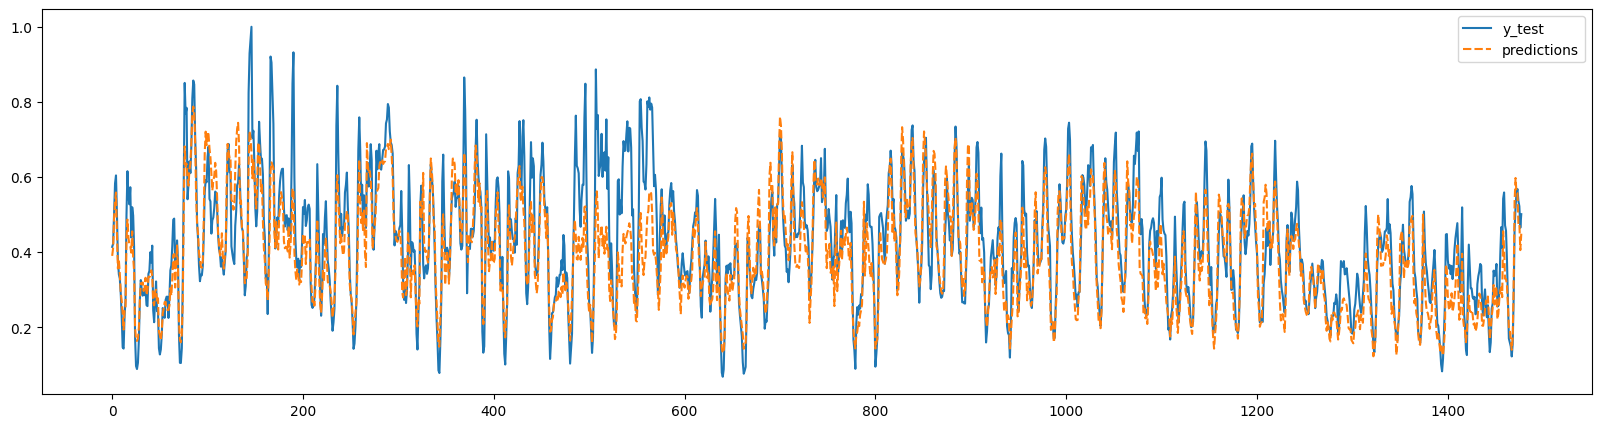

In [41]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:, :])
plt.show()

### MODEL TUNING

In [46]:
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

In [44]:
EPOCHS = 500
BATCH_SIZE = 32

metrics=[tfk.metrics.MeanAbsoluteError(), tfk.metrics.RootMeanSquaredError()]
normalize = tfkl.Normalization(axis=-1)
normalize.adapt(X_train)

In [51]:
tune = True

def model_builder(hp):
    model = tfk.Sequential()
    
    # Gaussian Noise layer
    # Apply additive zero-centered Gaussian noise.
    # This is useful to mitigate overfitting 
    # (you could see it as a form of random data augmentation). 
    # Gaussian Noise (GS) is a natural choice as corruption process for real valued inputs.
    hp_stddev = hp.Choice('stddev', values=[0.0, 0.05, 0.1, 0.2])
    if hp_stddev > 0:
        model.add(tfkl.GaussianNoise(hp_stddev))

    hp_units = hp.Int('units', min_value=64, max_value=512, step=64)
    model.add(tfkl.Dense(units=hp_units, activation='relu'))
    model.add(tfkl.BatchNormalization()),
    
    # Dropout level
    # Applies Dropout to the input.
    # The Dropout layer randomly sets input units to 0 with a frequency of rate
    # at each step during training time, which helps prevent overfitting. 
    # Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.    
    hp_rate = hp.Choice('rate', values=[0.0, 0.1, 0.2, 0.5])
    if hp_rate > 0:
        model.add(tfkl.Dropout(hp_rate))
        
    hp_num_layers = hp.Choice('num_layers', values=[1, 2, 3])
    
    if hp_num_layers > 1:
        
        hp_stddev_2 = hp.Choice('stddev_2', values=[0.0, 0.05, 0.1, 0.2])
        if hp_stddev_2 > 0:
            model.add(tfkl.GaussianNoise(hp_stddev_2))
        
        hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=16)
        model.add(tfkl.Dense(units=hp_units_2, activation='relu'))
        model.add(tfkl.BatchNormalization()),

        hp_rate_2 = hp.Choice('rate_2', values=[0.0, 0.1, 0.2, 0.5])
        if hp_rate_2 > 0:
            model.add(tfkl.Dropout(hp_rate_2))

    if hp_num_layers > 2:
        
        hp_stddev_3 = hp.Choice('stddev_3', values=[0.0, 0.05, 0.1, 0.2])
        if hp_stddev_3 > 0:
            model.add(tfkl.GaussianNoise(hp_stddev_3))
        
        hp_units_3 = hp.Int('units_3', min_value=64, max_value=512, step=64)
        model.add(tfkl.Dense(units=hp_units_2, activation='relu'))
        model.add(tfkl.BatchNormalization()),

        hp_rate_3 = hp.Choice('rate_3', values=[0.0, 0.1, 0.2, 0.5])
        if hp_rate_3 > 0:
            model.add(tfkl.Dropout(hp_rate_3))

    hp_learning_rate = hp.Choice('learning_rate', values=[0.02, 0.01, 0.005, 0.001])
    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=metrics,
    )
    
    return model
    
tuner = Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=EPOCHS,
                     factor=3,
                    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

if tune:
    tuner.search(X_train, y_train, epochs=EPOCHS, validation_split=0.2, callbacks=[stop_early])

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

    print('The hyperparameter search is complete.')
if tune:

    stddev = best_hps.get('stddev')
    if stddev > 0:
        print(f'Add GaussianNoise({stddev})')
    
    print(f'''The optimal number of units in the first densely-connected
    layer is {best_hps.get('units')}''')    

    rate = best_hps.get('rate')
    if rate > 0:
        print(f'Add Dropout({rate})')
    
    num_layers = best_hps.get('num_layers')
    if num_layers > 1:
        
        stddev_2 = best_hps.get('stddev_2')
        if stddev_2 > 0:
            print(f'Add GaussianNoise({stddev_2})')

        print(f'''The optimal number of units in the 2nd densely-connected
        layer is {best_hps.get('units_2')}''')    

        rate_2 = best_hps.get('rate_2')
        if rate_2 > 0:
            print(f'Add Dropout({rate_2})')

    if num_layers > 2:
        
        stddev_3 = best_hps.get('stddev_3')
        if stddev_3 > 0:
            print(f'Add GaussianNoise({stddev_3})')

        print(f'''The optimal number of units in the 3rd densely-connected
        layer is {best_hps.get('units_3')}''')    

        rate_3 = best_hps.get('rate_3')
        if rate_3 > 0:
            print(f'Add Dropout({rate_3})')

        
    print(f'''The optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.''')
    
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()

Trial 725 Complete [00h 00m 33s]
val_loss: 0.023704150691628456

Best val_loss So Far: 0.003026598831638694
Total elapsed time: 03h 01m 10s
The hyperparameter search is complete.
The optimal number of units in the first densely-connected
    layer is 256
Add GaussianNoise(0.2)
The optimal number of units in the 2nd densely-connected
        layer is 48
Add Dropout(0.1)
Add GaussianNoise(0.1)
The optimal number of units in the 3rd densely-connected
        layer is 128
The optimal learning rate for the optimizer
    is 0.005.


ValueError: ignored

In [53]:
if tune:

    stddev = best_hps.get('stddev')
    if stddev > 0:
        print(f'Add GaussianNoise({stddev})')
    
    print(f'''The optimal number of units in the first densely-connected
    layer is {best_hps.get('units')}''')    

    rate = best_hps.get('rate')
    if rate > 0:
        print(f'Add Dropout({rate})')
    
    num_layers = best_hps.get('num_layers')
    if num_layers > 1:
        
        stddev_2 = best_hps.get('stddev_2')
        if stddev_2 > 0:
            print(f'Add GaussianNoise({stddev_2})')

        print(f'''The optimal number of units in the 2nd densely-connected
        layer is {best_hps.get('units_2')}''')    

        rate_2 = best_hps.get('rate_2')
        if rate_2 > 0:
            print(f'Add Dropout({rate_2})')

    if num_layers > 2:
        
        stddev_3 = best_hps.get('stddev_3')
        if stddev_3 > 0:
            print(f'Add GaussianNoise({stddev_3})')

        print(f'''The optimal number of units in the 3rd densely-connected
        layer is {best_hps.get('units_3')}''')    

        rate_3 = best_hps.get('rate_3')
        if rate_3 > 0:
            print(f'Add Dropout({rate_3})')

        
    print(f'''The optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.''')
    
    best_model = tuner.get_best_models(num_models=1)[0]
    #best_model.summary()

The optimal number of units in the first densely-connected
    layer is 256
Add GaussianNoise(0.2)
The optimal number of units in the 2nd densely-connected
        layer is 48
Add Dropout(0.1)
Add GaussianNoise(0.1)
The optimal number of units in the 3rd densely-connected
        layer is 128
The optimal learning rate for the optimizer
    is 0.005.


In [54]:
best_model